# Predicting Insurance Premiums

- Our simple dataset contains a few attributes for each person such as
- Age, Sex, BMI, Children, Smoker, Region and their charges

## Aim
- To use this info to predict charges for new customers

In [1]:
import pandas as pd

# Uncomment this line if using this notebook locally
# insurance = pd.read_csv('./data/insurance/insurance.csv')

file_name = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/insurance.csv"
insurance = pd.read_csv(file_name)

# Preview our data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Outliers detected: 67 (5.01%)


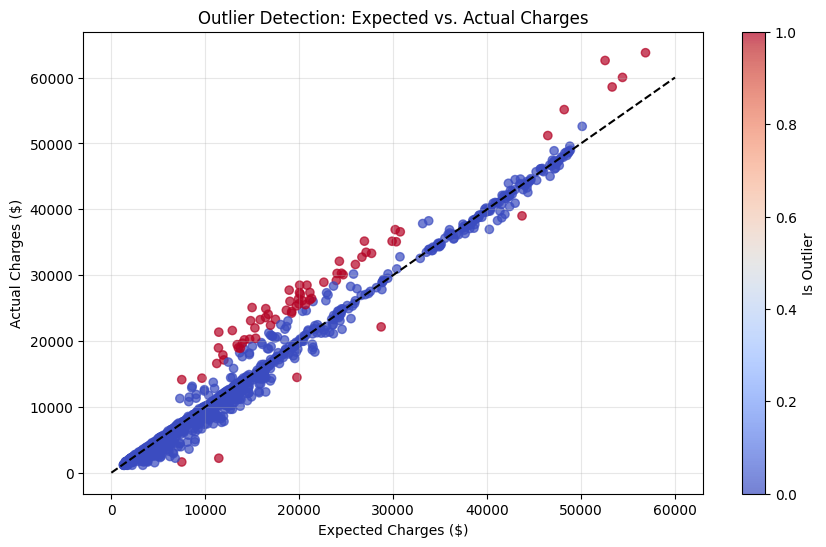


Original dataset size: 1338 records
After removing outliers: 1271 records
Removed 67 outlier records (5.01%)


In [2]:
# Add this after loading your dataset but before splitting it

# OUTLIER DETECTION SECTION
# =========================
# Import necessary libraries (if not already imported)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Create a copy of the original data to avoid modifying it
insurance_outlier = insurance.copy()

# Define features and target for outlier detection
X_outlier = insurance_outlier.drop(['charges', 'region'], axis=1)
y_outlier = insurance_outlier['charges']

# Create preprocessing for categorical features
outlier_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['sex', 'smoker'])
    ],
    remainder='passthrough')

# Build outlier detection model (using a separate model from your main one)
outlier_model = Pipeline([
    ('preprocessor', outlier_preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model on all data
outlier_model.fit(X_outlier, y_outlier)

# Calculate expected charges and residuals
expected_charges = outlier_model.predict(X_outlier)
insurance_outlier['expected_charges'] = expected_charges
insurance_outlier['residual'] = insurance_outlier['charges'] - expected_charges
insurance_outlier['abs_residual'] = np.abs(insurance_outlier['residual'])

# Define outlier threshold
std_residual = np.std(insurance_outlier['residual'])
threshold = 2.5 * std_residual
insurance_outlier['is_outlier'] = insurance_outlier['abs_residual'] > threshold

# Calculate outlier metrics
outlier_count = insurance_outlier['is_outlier'].sum()
outlier_percent = outlier_count / len(insurance_outlier) * 100
print(f"Outliers detected: {outlier_count} ({outlier_percent:.2f}%)")

# Visualize outliers
plt.figure(figsize=(10, 6))
plt.scatter(insurance_outlier['expected_charges'], insurance_outlier['charges'],
            c=insurance_outlier['is_outlier'], cmap='coolwarm', alpha=0.7)
plt.plot([0, 60000], [0, 60000], 'k--')
plt.colorbar(label='Is Outlier')
plt.xlabel('Expected Charges ($)')
plt.ylabel('Actual Charges ($)')
plt.title('Outlier Detection: Expected vs. Actual Charges')
plt.grid(alpha=0.3)
plt.show()

# Filter out outliers
insurance = insurance.loc[~insurance_outlier['is_outlier']].reset_index(drop=True)
print(f"\nOriginal dataset size: {len(insurance_outlier)} records")
print(f"After removing outliers: {len(insurance)} records")
print(f"Removed {len(insurance_outlier) - len(insurance)} outlier records ({outlier_percent:.2f}%)")
# END OF OUTLIER DETECTION SECTION
# ===============================

# Now continue with your original code using the cleaned 'insurance' dataframe

In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1271 entries, 0 to 1270
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1271 non-null   int64  
 1   sex       1271 non-null   object 
 2   bmi       1271 non-null   float64
 3   children  1271 non-null   int64  
 4   smoker    1271 non-null   object 
 5   region    1271 non-null   object 
 6   charges   1271 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 69.6+ KB


In [4]:
insurance.describe()

,age,bmi,children,charges
count,1271.000000,1271.000000,1271.000000,1271.000000
mean,39.263572,30.624921,1.096774,12506.025761
std,14.043709,6.112869,1.211200,11629.425391
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.220000,0.000000,4562.015300
50%,39.000000,30.305000,1.000000,8835.264950
75%,51.000000,34.590000,2.000000,14244.840100
max,64.000000,53.130000,5.000000,52590.829390


In [5]:
print ("Rows     : " , insurance.shape[0])
print ("Columns  : " , insurance.shape[1])
print ("\nFeatures : \n" , insurance.columns.tolist())
print ("\nMissing values :  ", insurance.isnull().sum().values.sum())
print ("\nUnique values :  \n",insurance.nunique())

Rows     :  1271
Columns  :  7

Features : 
 ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

Missing values :   0

Unique values :  
 age           47
sex            2
bmi          540
children       6
smoker         2
region         4
charges     1270
dtype: int64


In [6]:
insurance.corr(numeric_only=True)

,age,bmi,children,charges
age,1.000000,0.109350,0.038449,0.314205
bmi,0.109350,1.000000,0.011360,0.200349
children,0.038449,0.011360,1.000000,0.071669
charges,0.314205,0.200349,0.071669,1.000000


/tmp/ipykernel_54025/820532227.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


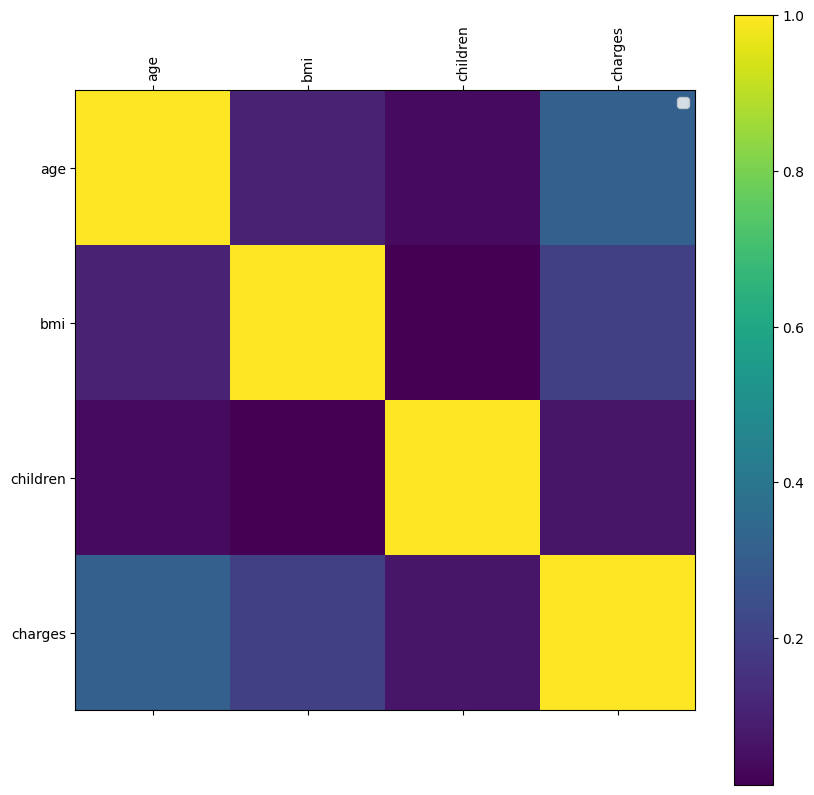

In [7]:
import matplotlib.pyplot as plt

def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(size, size))
    ax.legend()
    cax = ax.matshow(corr)
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
    plt.yticks(range(len(corr.columns)), corr.columns)

plot_corr(insurance)

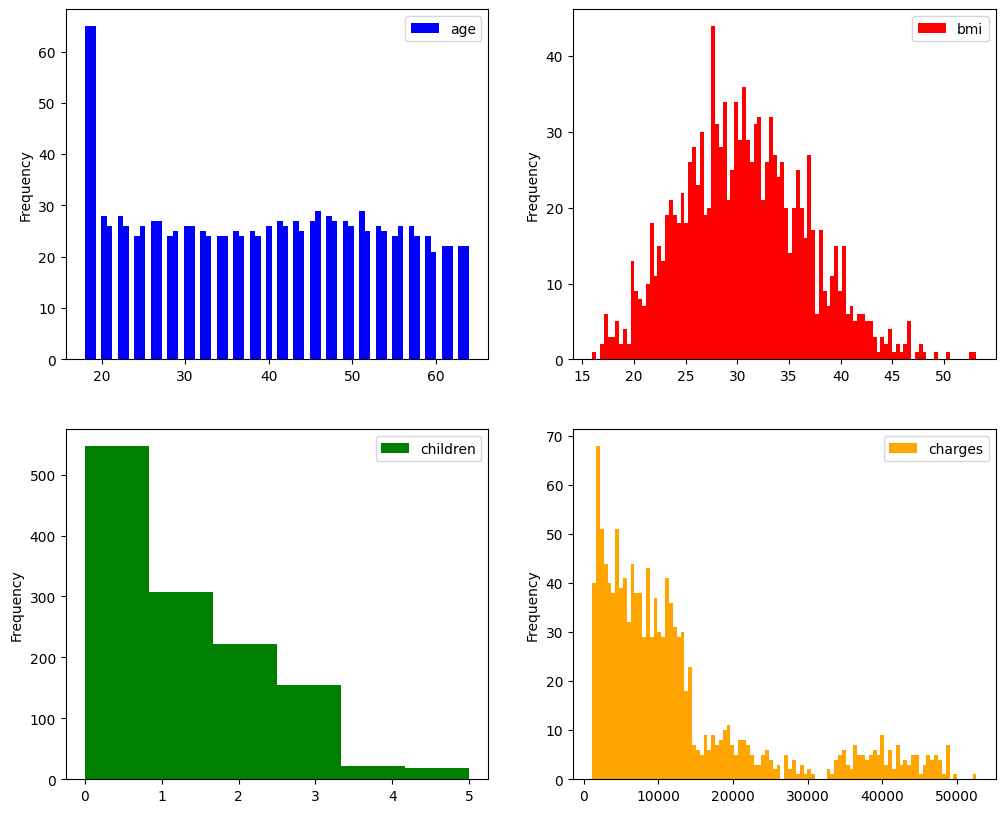

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
insurance.plot(kind="hist", y="age", bins=70, color="b", ax=axes[0][0])
insurance.plot(kind="hist", y="bmi", bins=100, color="r", ax=axes[0][1])
insurance.plot(kind="hist", y="children", bins=6, color="g", ax=axes[1][0])
insurance.plot(kind="hist", y="charges", bins=100, color="orange", ax=axes[1][1])
plt.show()

<Axes: xlabel='sex'>

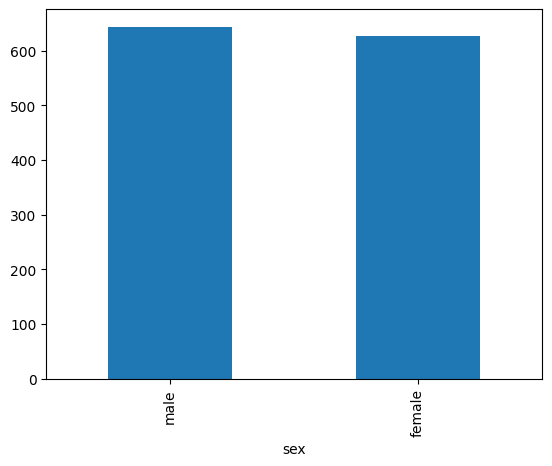

In [9]:
insurance['sex'].value_counts().plot(kind='bar')

<Axes: xlabel='smoker'>

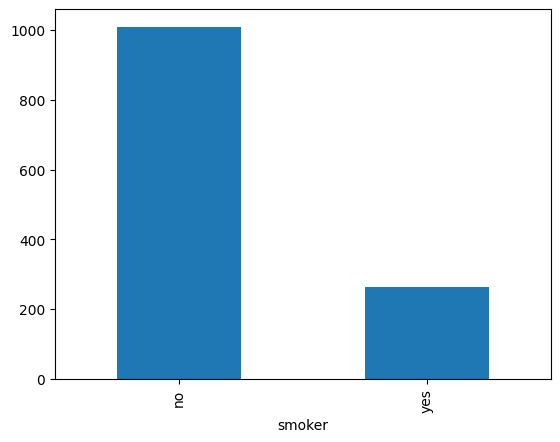

In [10]:
insurance['smoker'].value_counts().plot(kind='bar')

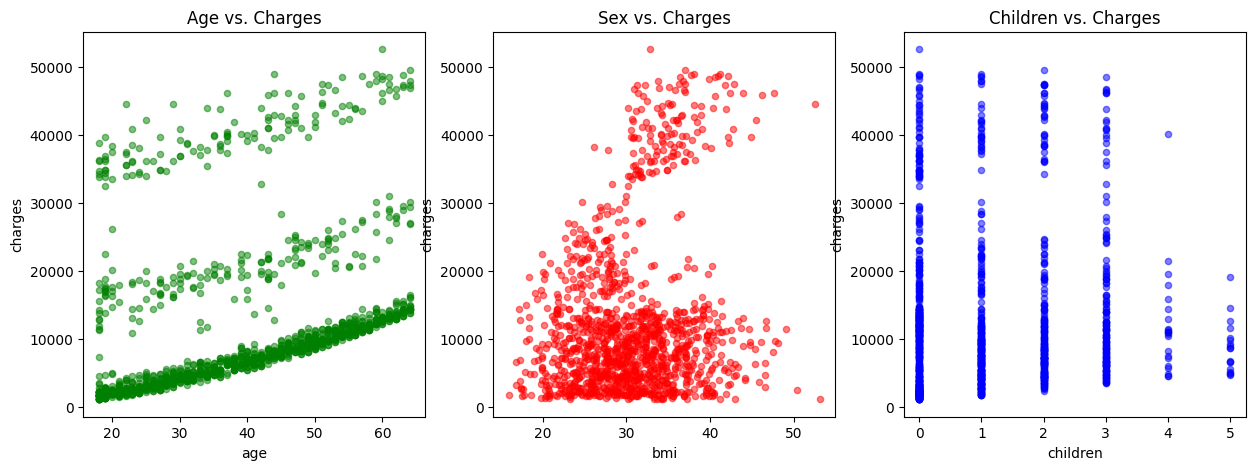

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
insurance.plot(kind='scatter', x='age', y='charges', alpha=0.5, color='green', ax=axes[0], title="Age vs. Charges")
insurance.plot(kind='scatter', x='bmi', y='charges', alpha=0.5, color='red', ax=axes[1], title="Sex vs. Charges")
insurance.plot(kind='scatter', x='children', y='charges', alpha=0.5, color='blue', ax=axes[2], title="Children vs. Charges")
plt.show()

<Axes: xlabel='bmi', ylabel='charges'>

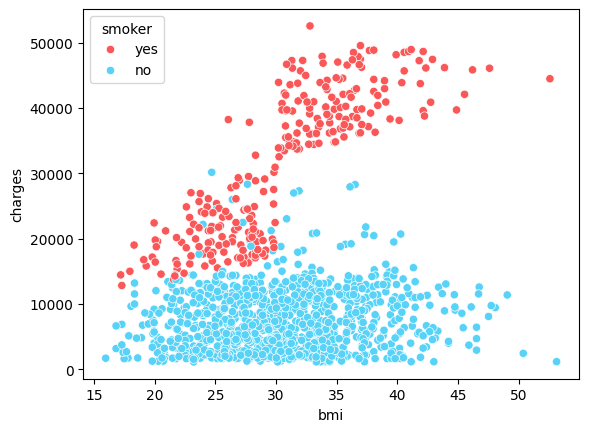

In [12]:
import seaborn as sns  # Imorting Seaborn library
pal = ["#FA5858", "#58D3F7"]
sns.scatterplot(x="bmi", y="charges", data=insurance, palette=pal, hue='smoker')

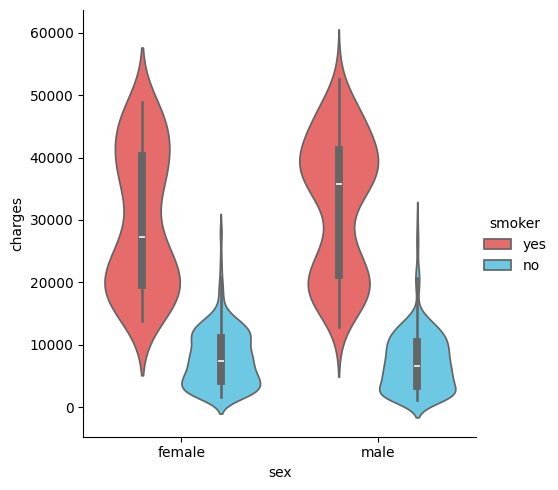

In [13]:
pal = ["#FA5858", "#58D3F7"]
sns.catplot(x="sex", y="charges", hue="smoker",
            kind="violin", data=insurance, palette = pal)

Text(0.5, 1.0, 'Smokers')

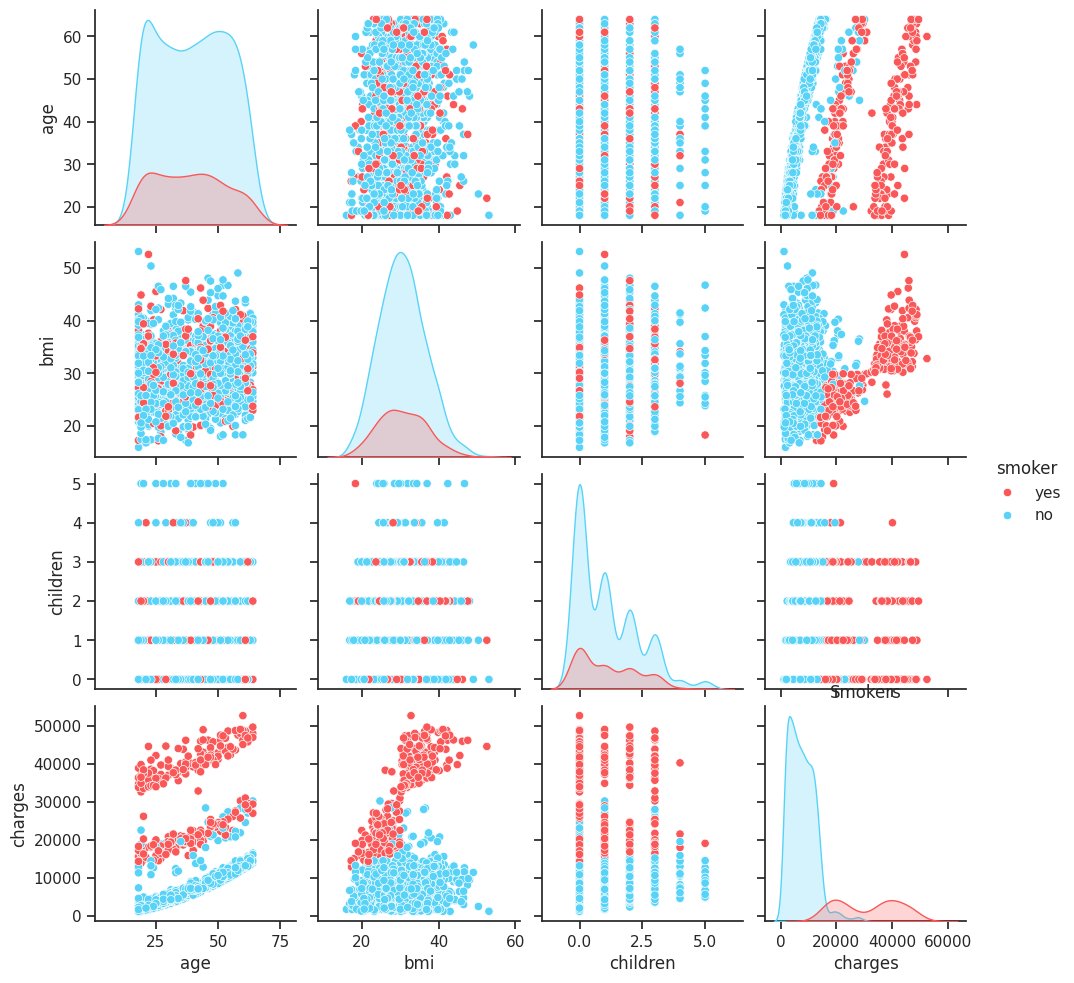

In [14]:
import seaborn as sns

sns.set(style="ticks")
pal = ["#FA5858", "#58D3F7"]

sns.pairplot(insurance, hue="smoker", palette=pal)
plt.title("Smokers")

# Preparing Data for Machine Learning Algorithms

In [15]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620
3,32,male,28.88,0,no,northwest,3866.8552
4,31,female,25.74,0,no,southeast,3756.6216


In [16]:
insurance['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [17]:
insurance.drop(["region"], axis=1, inplace=True)
insurance.head()

,age,sex,bmi,children,smoker,charges
0,19,female,27.90,0,yes,16884.9240
1,18,male,33.77,1,no,1725.5523
2,28,male,33.00,3,no,4449.4620
3,32,male,28.88,0,no,3866.8552
4,31,female,25.74,0,no,3756.6216


In [18]:
# Changing binary categories to 1s and 0s
insurance['sex'] = insurance['sex'].map(lambda s :1  if s == 'female' else 0)
insurance['smoker'] = insurance['smoker'].map(lambda s :1  if s == 'yes' else 0)

insurance.head()

,age,sex,bmi,children,smoker,charges
0,19,1,27.90,0,1,16884.9240
1,18,0,33.77,1,0,1725.5523
2,28,0,33.00,3,0,4449.4620
3,32,0,28.88,0,0,3866.8552
4,31,1,25.74,0,0,3756.6216


In [19]:
X = insurance.drop(['charges'], axis = 1)
y = insurance.charges

# Modeling our Data

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
lr = LinearRegression().fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(lr.score(X_test, y_test))

0.8312540899181637


**Score** is the R2 score, which varies between 0 and 100%. It is closely related to the MSE but not the same.

Wikipedia defines r2 like this, ” … is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).” Another definition is “(total variance explained by model) / total variance.” So if it is 100%, the two variables are perfectly correlated, i.e., with no variance at all. A low value would show a low level of correlation, meaning a regression model that is not valid, but not in all cases.

In [21]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
results

,Actual,Predicted
1176,47269.85400,38650.240879
1117,6496.88600,6810.653562
427,5910.94400,7062.987161
351,3481.86800,2567.872451
364,20781.48892,11721.930212
...,...,...
271,11879.10405,12232.361104
669,10264.44210,10103.714191
552,4779.60230,5256.550523
122,9634.53800,12560.243001


In [22]:
# Normalize the data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [23]:
pd.DataFrame(X_train).head()

,0,1,2,3,4
0,-0.464056,-0.980258,-0.958518,-0.91591,1.946521
1,1.189331,-0.980258,1.582718,-0.91591,-0.513737
2,-1.470465,-0.980258,-0.498784,-0.91591,-0.513737
3,1.764423,1.020140,-0.615971,-0.91591,1.946521
4,-1.039147,1.020140,-0.072650,-0.91591,1.946521


In [24]:
pd.DataFrame(y_train).head()

,charges
760,17904.52705
16,10602.38500
752,1252.40700
848,29330.98315
1242,33900.65300


In [25]:
from sklearn.linear_model import LinearRegression  # Import Linear Regression model

multiple_linear_reg = LinearRegression(fit_intercept=False)  # Create a instance for Linear Regression model
multiple_linear_reg.fit(X_train, y_train)  # Fit data to the model

LinearRegression(fit_intercept=False)

In [26]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=3)  # Create a PolynomialFeatures instance in degree 3
x_train_poly = polynomial_features.fit_transform(X_train)  # Fit and transform the training data to polynomial
x_test_poly = polynomial_features.fit_transform(X_test)  # Fit and transform the testing data to polynomial

polynomial_reg = LinearRegression(fit_intercept=False)  # Create a instance for Linear Regression model
polynomial_reg.fit(x_train_poly, y_train)  # Fit data to the model

LinearRegression(fit_intercept=False)

In [27]:
from sklearn.tree import DecisionTreeRegressor  # Import Decision Tree Regression model

decision_tree_reg = DecisionTreeRegressor(max_depth=5, random_state=13)  # Create a instance for Decision Tree Regression model
decision_tree_reg.fit(X_train, y_train)  # Fit data to the model

DecisionTreeRegressor(max_depth=5, random_state=13)

In [28]:
from sklearn.ensemble import RandomForestRegressor  # Import Random Forest Regression model

random_forest_reg = RandomForestRegressor(n_estimators=400, max_depth=5, random_state=13)  # Create a instance for Random Forest Regression model
random_forest_reg.fit(X_train, y_train)  # Fit data to the model

RandomForestRegressor(max_depth=5, n_estimators=400, random_state=13)

**NOTE:**
**n_estimators** represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

In [29]:
from sklearn.svm import SVR  # Import SVR model

support_vector_reg = SVR(gamma="auto", kernel="linear", C=1000)  # Create a instance for Support Vector Regression model
support_vector_reg.fit(X_train, y_train)  # Fit data to the model

SVR(C=1000, gamma='auto', kernel='linear')

In [30]:
from sklearn.model_selection import cross_val_predict  # For K-Fold Cross Validation
from sklearn.metrics import r2_score  # For find accuracy with R2 Score
from sklearn.metrics import mean_squared_error  # For MSE
from math import sqrt  # For squareroot operation

### Evaluating Multiple Linear Regression Model

In [31]:
# Prediction with training dataset:
y_pred_MLR_train = multiple_linear_reg.predict(X_train)

# Prediction with testing dataset:
y_pred_MLR_test = multiple_linear_reg.predict(X_test)

# Find training accuracy for this model:
accuracy_MLR_train = r2_score(y_train, y_pred_MLR_train)
print("Training Accuracy for Multiple Linear Regression Model: ", accuracy_MLR_train)

# Find testing accuracy for this model:
accuracy_MLR_test = r2_score(y_test, y_pred_MLR_test)
print("Testing Accuracy for Multiple Linear Regression Model: ", accuracy_MLR_test)

# Find RMSE for training data:
RMSE_MLR_train = sqrt(mean_squared_error(y_train, y_pred_MLR_train))
print("RMSE for Training Data: ", RMSE_MLR_train)

# Find RMSE for testing data:
RMSE_MLR_test = sqrt(mean_squared_error(y_test, y_pred_MLR_test))
print("RMSE for Testing Data: ", RMSE_MLR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_MLR = cross_val_predict(multiple_linear_reg, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_MLR = r2_score(y, y_pred_cv_MLR)
print("Accuracy for 10-Fold Cross Predicted Multiple Linaer Regression Model: ", accuracy_cv_MLR)

Training Accuracy for Multiple Linear Regression Model:  -0.3586430004915673
Testing Accuracy for Multiple Linear Regression Model:  -0.33663213573881845
RMSE for Training Data:  13503.539681290433
RMSE for Testing Data:  13569.841070395272
Accuracy for 10-Fold Cross Predicted Multiple Linaer Regression Model:  0.7913650460816373


###  Evaluating Polynomial Regression Model

In [32]:
# Prediction with training dataset:
y_pred_PR_train = polynomial_reg.predict(x_train_poly)

# Prediction with testing dataset:
y_pred_PR_test = polynomial_reg.predict(x_test_poly)

# Find training accuracy for this model:
accuracy_PR_train = r2_score(y_train, y_pred_PR_train)
print("Training Accuracy for Polynomial Regression Model: ", accuracy_PR_train)

# Find testing accuracy for this model:
accuracy_PR_test = r2_score(y_test, y_pred_PR_test)
print("Testing Accuracy for Polynomial Regression Model: ", accuracy_PR_test)

# Find RMSE for training data:
RMSE_PR_train = sqrt(mean_squared_error(y_train, y_pred_PR_train))
print("RMSE for Training Data: ", RMSE_PR_train)

# Find RMSE for testing data:
RMSE_PR_test = sqrt(mean_squared_error(y_test, y_pred_PR_test))
print("RMSE for Testing Data: ", RMSE_PR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_PR = cross_val_predict(polynomial_reg, polynomial_features.fit_transform(X), y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_PR = r2_score(y, y_pred_cv_PR)
print("Accuracy for 10-Fold Cross Predicted Polynomial Regression Model: ", accuracy_cv_PR)

Training Accuracy for Polynomial Regression Model:  0.9334167210975552
Testing Accuracy for Polynomial Regression Model:  0.9342998989563168
RMSE for Training Data:  2989.3553002667013
RMSE for Testing Data:  3008.5125729799765
Accuracy for 10-Fold Cross Predicted Polynomial Regression Model:  0.9280479013302788


###  Evaluating Decision Tree Regression Model

In [33]:
# Prediction with training dataset:
y_pred_DTR_train = decision_tree_reg.predict(X_train)

# Prediction with testing dataset:
y_pred_DTR_test = decision_tree_reg.predict(X_test)

# Find training accuracy for this model:
accuracy_DTR_train = r2_score(y_train, y_pred_DTR_train)
print("Training Accuracy for Decision Tree Regression Model: ", accuracy_DTR_train)

# Find testing accuracy for this model:
accuracy_DTR_test = r2_score(y_test, y_pred_DTR_test)
print("Testing Accuracy for Decision Tree Regression Model: ", accuracy_DTR_test)

# Find RMSE for training data:
RMSE_DTR_train = sqrt(mean_squared_error(y_train, y_pred_DTR_train))
print("RMSE for Training Data: ", RMSE_DTR_train)

# Find RMSE for testing data:
RMSE_DTR_test = sqrt(mean_squared_error(y_test, y_pred_DTR_test))
print("RMSE for Testing Data: ", RMSE_DTR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_DTR = cross_val_predict(decision_tree_reg, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_DTR = r2_score(y, y_pred_cv_DTR)
print("Accuracy for 10-Fold Cross Predicted Decision Tree Regression Model: ", accuracy_cv_DTR)

Training Accuracy for Decision Tree Regression Model:  0.9596675105006858
Testing Accuracy for Decision Tree Regression Model:  0.9500506820389077
RMSE for Training Data:  2326.6039539887074
RMSE for Testing Data:  2623.2132257762582
Accuracy for 10-Fold Cross Predicted Decision Tree Regression Model:  0.9429955793251309


### Evaluating Random Forest Regression Model

In [34]:
# Prediction with training dataset:
y_pred_RFR_train = random_forest_reg.predict(X_train)

# Prediction with testing dataset:
y_pred_RFR_test = random_forest_reg.predict(X_test)

# Find training accuracy for this model:
accuracy_RFR_train = r2_score(y_train, y_pred_RFR_train)
print("Training Accuracy for Random Forest Regression Model: ", accuracy_RFR_train)

# Find testing accuracy for this model:
accuracy_RFR_test = r2_score(y_test, y_pred_RFR_test)
print("Testing Accuracy for Random Forest Regression Model: ", accuracy_RFR_test)

# Find RMSE for training data:
RMSE_RFR_train = sqrt(mean_squared_error(y_train, y_pred_RFR_train))
print("RMSE for Training Data: ", RMSE_RFR_train)

# Find RMSE for testing data:
RMSE_RFR_test = sqrt(mean_squared_error(y_test, y_pred_RFR_test))
print("RMSE for Testing Data: ", RMSE_RFR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_RFR = cross_val_predict(random_forest_reg, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_RFR = r2_score(y, y_pred_cv_RFR)
print("Accuracy for 10-Fold Cross Predicted Random Forest Regression Model: ", accuracy_cv_RFR)

Training Accuracy for Random Forest Regression Model:  0.9639311711776765
Testing Accuracy for Random Forest Regression Model:  0.9529758369862042
RMSE for Training Data:  2200.193956827332
RMSE for Testing Data:  2545.243571301624
Accuracy for 10-Fold Cross Predicted Random Forest Regression Model:  0.9514612511826646


In [35]:
import numpy as np


In [36]:
# Ensure feature names are consistent
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Function to calculate prediction intervals
def prediction_intervals(model, X, percentile=95):
    predictions = [tree.predict(X) for tree in model.estimators_]
    predictions = np.array(predictions)
    lower_bound = np.percentile(predictions, (100 - percentile) / 2.0, axis=0)
    upper_bound = np.percentile(predictions, 100 - (100 - percentile) / 2.0, axis=0)
    return lower_bound, upper_bound

# Calculate 95% prediction intervals for testing data
lower, upper = prediction_intervals(random_forest_reg, X_test_df, percentile=95)

# Display the results
results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_RFR_test,
    "Lower Bound": lower,
    "Upper Bound": upper
})

print(results.head())

# Save the results to a CSV file
results.to_csv("insurance_predictions_with_intervals.csv", index=False)
print("Prediction intervals saved to insurance_predictions_with_intervals.csv")

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/codespace/.loc

           Actual     Predicted   Lower Bound   Upper Bound
1176  47269.85400  44590.404775  42261.729802  47336.103855
1117   6496.88600   6812.417653   5895.796129   7741.282957
427    5910.94400   6582.658886   4710.013290   7614.540672
351    3481.86800   6946.631503   2028.696191  18838.703660
364   20781.48892  11714.868656  10846.317099  12566.782521
Prediction intervals saved to insurance_predictions_with_intervals.csv


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/codespace/.loc

### Evaluating Support Vector Regression Model

In [37]:
# Prediction with training dataset:
y_pred_SVR_train = support_vector_reg.predict(X_train)

# Prediction with testing dataset:
y_pred_SVR_test = support_vector_reg.predict(X_test)

# Find training accuracy for this model:
accuracy_SVR_train = r2_score(y_train, y_pred_SVR_train)
print("Training Accuracy for Support Vector Regression Model: ", accuracy_SVR_train)

# Find testing accuracy for this model:
accuracy_SVR_test = r2_score(y_test, y_pred_SVR_test)
print("Testing Accuracy for Support Vector Regression Model: ", accuracy_SVR_test)

# Find RMSE for training data:
RMSE_SVR_train = sqrt(mean_squared_error(y_train, y_pred_SVR_train))
print("RMSE for Training Data: ", RMSE_SVR_train)

# Find RMSE for testing data:
RMSE_SVR_test = sqrt(mean_squared_error(y_test, y_pred_SVR_test))
print("RMSE for Testing Data: ", RMSE_SVR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_SVR = cross_val_predict(support_vector_reg, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_SVR = r2_score(y, y_pred_cv_SVR)
print("Accuracy for 10-Fold Cross Predicted Support Vector Regression Model: ", accuracy_cv_SVR)

Training Accuracy for Support Vector Regression Model:  0.7461042352043433
Testing Accuracy for Support Vector Regression Model:  0.7439331139200549
RMSE for Training Data:  5837.443302143978
RMSE for Testing Data:  5939.440310722308
Accuracy for 10-Fold Cross Predicted Support Vector Regression Model:  0.7382440215512251


In [38]:
# Compare all results in one table
training_accuracies = [accuracy_MLR_train, accuracy_PR_train, accuracy_DTR_train, accuracy_RFR_train, accuracy_SVR_train]
testing_accuracies = [accuracy_MLR_test, accuracy_PR_test, accuracy_DTR_test, accuracy_RFR_test, accuracy_SVR_test]
training_RMSE = [RMSE_MLR_train, RMSE_PR_train, RMSE_DTR_train, RMSE_RFR_train, RMSE_SVR_train]
testing_RMSE = [RMSE_MLR_test, RMSE_PR_test, RMSE_DTR_test, RMSE_RFR_test, RMSE_SVR_test]
cv_accuracies = [accuracy_cv_MLR, accuracy_cv_PR, accuracy_cv_DTR, accuracy_cv_RFR, accuracy_cv_SVR]

parameters = ["fit_intercept=False", "fit_intercept=False", "max_depth=5", "n_estimators=400, max_depth=5", "kernel=”linear”, C=1000"]

table_data = {"Parameters": parameters, "Training Accuracy": training_accuracies, "Testing Accuracy": testing_accuracies,
              "Training RMSE": training_RMSE, "Testing RMSE": testing_RMSE, "10-Fold Score": cv_accuracies}
model_names = ["Multiple Linear Regression", "Polynomial Regression", "Decision Tree Regression", "Random Forest Regression", "Support Vector Regression"]

table_dataframe = pd.DataFrame(data=table_data, index=model_names)
table_dataframe

,Parameters,Training Accuracy,Testing Accuracy,Training RMSE,Testing RMSE,10-Fold Score
Multiple Linear Regression,fit_intercept=False,-0.358643,-0.336632,13503.539681,13569.841070,0.791365
Polynomial Regression,fit_intercept=False,0.933417,0.934300,2989.355300,3008.512573,0.928048
Decision Tree Regression,max_depth=5,0.959668,0.950051,2326.603954,2623.213226,0.942996
Random Forest Regression,"n_estimators=400, max_depth=5",0.963931,0.952976,2200.193957,2545.243571,0.951461
Support Vector Regression,"kernel=”linear”, C=1000",0.746104,0.743933,5837.443302,5939.440311,0.738244


### Our best classifier is our Random Forests using 400 estimators and a max_depth of 5

**R^2 (coefficient of determination) regression score function.**

Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

# Let's test our best regression on some new data

In [39]:
input_data = {'age': [35],
              'sex': ['male'],
              'bmi': [26],
              'children': [0],
              'smoker': ['no'],
              'region': ['southeast']}

input_data = pd.DataFrame(input_data)
input_data

,age,sex,bmi,children,smoker,region
0,35,male,26,0,no,southeast


In [40]:
# Our simple pre-processing
input_data.drop(["region"], axis=1, inplace=True)
input_data['sex'] = input_data['sex'].map(lambda s :1  if s == 'female' else 0)
input_data['smoker'] = input_data['smoker'].map(lambda s :1  if s == 'yes' else 0)
input_data

,age,sex,bmi,children,smoker
0,35,0,26,0,0


In [41]:
# Scale our input data
input_data = sc.transform(input_data)
input_data

array([[-0.32028295, -0.9802578 , -0.76102069, -0.9159096 , -0.51373702]])

In [42]:
# Reshape our input data in the format required by sklearn models
input_data = input_data.reshape(1, -1)
print(input_data.shape)
input_data

(1, 5)


array([[-0.32028295, -0.9802578 , -0.76102069, -0.9159096 , -0.51373702]])

In [43]:
# Get our predicted insurance rate for our new customer
random_forest_reg.predict(input_data)

array([5412.38578902])

In [44]:
# Note Standard Scaler remembers your inputs so you can use it still here
print(sc.mean_)
print(sc.scale_)

[39.45540399  0.49003148 30.64326338  1.11647429  0.20881427]
[13.91083714  0.49990062  6.1013629   1.2189787   0.4064614 ]


In [45]:
insurance = insurance.drop_duplicates()

In [46]:
#stacking ensemble:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the data
url = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/insurance.csv"
data = pd.read_csv(url)

# Preprocess the data
data = pd.get_dummies(data, drop_first=True)
X = data.drop('charges', axis=1)
y = data['charges']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, "scaler.pkl")

# Define base learners
base_learners = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
]

# Define meta learner
meta_learner = LinearRegression()

# Define stacking ensemble
stacking_model = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)

# Train the model
stacking_model.fit(X_train, y_train)

# Save the stacking model
joblib.dump(stacking_model, "stacking_model.pkl")

# Make predictions on training and testing sets
y_train_pred = stacking_model.predict(X_train)
y_test_pred = stacking_model.predict(X_test)

# Evaluate the model
accuracy_SR_train = r2_score(y_train, y_train_pred)
accuracy_SR_test = r2_score(y_test, y_test_pred)
RMSE_SR_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_SR_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
accuracy_cv_SR = cross_val_score(stacking_model, X, y, cv=10, scoring='r2')

# Print the results
print("Parameters:")
print(f"Base Learners: {base_learners}")
print(f"Meta Learner: {meta_learner}")
print(f"Training Accuracy (R^2): {accuracy_SR_test}")
print(f"Testing Accuracy (R^2): {accuracy_SR_test}")
print(f"Training RMSE: {RMSE_SR_train}")
print(f"Testing RMSE: {RMSE_SR_test}")
print(f"10-Fold Score: {accuracy_cv_SR.mean()}")


#testing on new data:

import pandas as pd
import numpy as np
import joblib

# Load the input data
input_data = {'age': [35],
              'sex': ['male'],
              'bmi': [26],
              'children': [0],
              'smoker': ['no'],
              'region': ['southeast']}
input_data = pd.DataFrame(input_data)

# Preprocess the input data (assuming same preprocessing steps)
input_data = pd.get_dummies(input_data, drop_first=True)

# Ensure the input data has the same columns as the training data
X_train_columns = ['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']
missing_cols = set(X_train_columns) - set(input_data.columns)
for col in missing_cols:
    input_data[col] = 0
input_data = input_data[X_train_columns]

# Load the scaler
scaler = joblib.load("scaler.pkl")

# Standardize the input data
input_data_scaled = scaler.transform(input_data)

# Reshape our input data in the format required by sklearn models
input_data_scaled = input_data_scaled.reshape(1, -1)
print(input_data_scaled.shape)

# Load the trained stacking ensemble model
stacking_model = joblib.load("stacking_model.pkl")

# Get our predicted insurance rate for our new customer
predicted_charges = stacking_model.predict(input_data_scaled)
print(f"Predicted charges for the input data: {predicted_charges[0]}")

# Note Standard Scaler remembers your inputs so you can use it still here
print("Mean used by StandardScaler:", scaler.mean_)
print("Scale used by StandardScaler:", scaler.scale_)


Parameters:
Base Learners: [('lr', LinearRegression()), ('dt', DecisionTreeRegressor(random_state=42)), ('rf', RandomForestRegressor(random_state=42))]
Meta Learner: LinearRegression()
Training Accuracy (R^2): 0.8720758523045165
Testing Accuracy (R^2): 0.8720758523045165
Training RMSE: 2668.5581089879015
Testing RMSE: 4456.462908730432
10-Fold Score: 0.8407874391587026
(1, 8)
Predicted charges for the input data: 5104.622909098958
Mean used by StandardScaler: [39.35700935 30.5603972   1.10747664  0.51214953  0.20560748  0.23925234
  0.26448598  0.24672897]
Scale used by StandardScaler: [14.06738199  6.040561    1.21541508  0.49985237  0.40414483  0.42662707
  0.44105912  0.43110763]


In [47]:
from sklearn.linear_model import BayesianRidge


bayesian_reg = BayesianRidge(max_iter=500)
bayesian_reg.fit(X_train, y_train)

# Prediction with training dataset:
y_pred_BR_train = bayesian_reg.predict(X_train)


# Prediction with testing dataset:
y_pred_BR_test = bayesian_reg.predict(X_test)


# Find training accuracy for this model:
accuracy_BR_train = r2_score(y_train, y_pred_BR_train)
print("Training Accuracy for Bayesian Regression Model: ", accuracy_BR_train)


# Find testing accuracy for this model:
accuracy_BR_test = r2_score(y_test, y_pred_BR_test)
print("Testing Accuracy for Bayesian Regression Model: ", accuracy_BR_test)


# Find RMSE for training data:
RMSE_BR_train = sqrt(mean_squared_error(y_train, y_pred_BR_train))
print("RMSE for Training Data: ", RMSE_BR_train)


# Find RMSE for testing data:
RMSE_BR_test = sqrt(mean_squared_error(y_test, y_pred_BR_test))
print("RMSE for Testing Data: ", RMSE_BR_test)


# Prediction with 10-Fold Cross Validation:
y_pred_cv_BR = cross_val_predict(bayesian_reg, X, y, cv=10)


# Find accuracy after 10-Fold Cross Validation
accuracy_cv_BR = r2_score(y, y_pred_cv_BR)
print("Accuracy for 10-Fold Cross Predicted Bayesian Regression Model: ", accuracy_cv_BR)

# Compare all results in one table
training_accuracies = [accuracy_MLR_train, accuracy_PR_train, accuracy_DTR_train, accuracy_RFR_train, accuracy_SVR_train, accuracy_BR_train]
testing_accuracies = [accuracy_MLR_test, accuracy_PR_test, accuracy_DTR_test, accuracy_RFR_test, accuracy_SVR_test, accuracy_BR_test]
training_RMSE = [RMSE_MLR_train, RMSE_PR_train, RMSE_DTR_train, RMSE_RFR_train, RMSE_SVR_train, RMSE_BR_train]
testing_RMSE = [RMSE_MLR_test, RMSE_PR_test, RMSE_DTR_test, RMSE_RFR_test, RMSE_SVR_test, RMSE_BR_test]
cv_accuracies = [accuracy_cv_MLR, accuracy_cv_PR, accuracy_cv_DTR, accuracy_cv_RFR, accuracy_cv_SVR, accuracy_cv_BR]


parameters = ["fit_intercept=False", "fit_intercept=False", "max_depth=5", "n_estimators=400, max_depth=5", "kernel=”linear”, C=1000", "max_iter=500"]


table_data = {"Parameters": parameters, "Training Accuracy": training_accuracies, "Testing Accuracy": testing_accuracies,
             "Training RMSE": training_RMSE, "Testing RMSE": testing_RMSE, "10-Fold Score": cv_accuracies}
model_names = ["Multiple Linear Regression", "Polynomial Regression", "Decision Tree Regression", "Random Forest Regression", "Support Vector Regression", "Bayesian Regression"]

#testing bayesian:

bayesian_reg.predict(input_data)

Training Accuracy for Bayesian Regression Model:  0.7417203882765029
Testing Accuracy for Bayesian Regression Model:  0.7834467350138165
RMSE for Training Data:  6105.606589974451
RMSE for Testing Data:  5798.242810499306
Accuracy for 10-Fold Cross Predicted Bayesian Regression Model:  0.7475804718327597


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(


array([192329.25480064])

**Gradient**


Gradient Boosting Regressor Performance:
Training R²: 0.890398
Testing R²: 0.879904
Cross-validation R²: 0.858393
Training RMSE: 3977.344329
Testing RMSE: 4317.952735
Training MAE: 2207.478737
Testing MAE: 2470.863620
Training MAPE: 27.928505%
Testing MAPE: 34.325468%


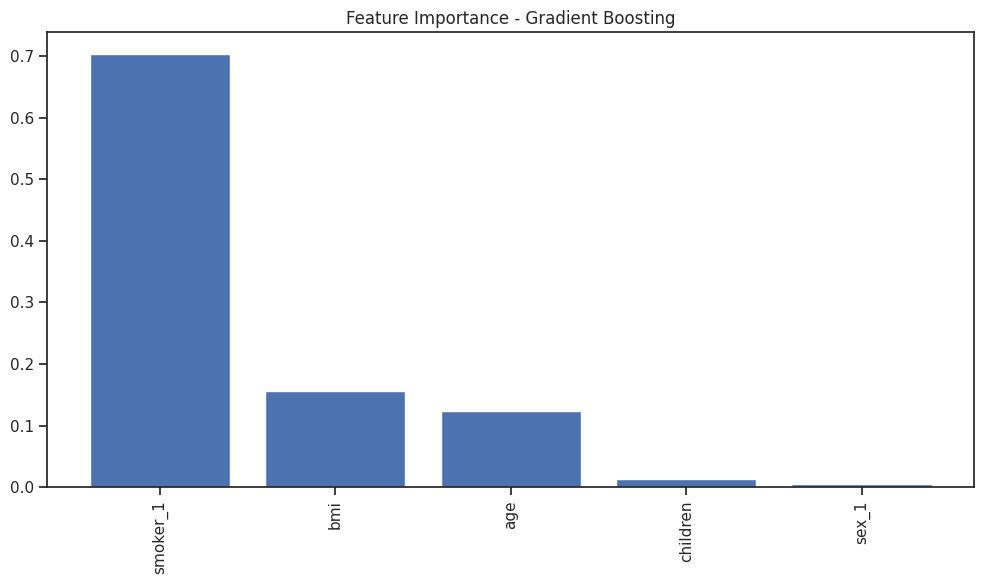

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Load the dataset
insurance_data = pd.read_csv('https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv')

insurance_data['sex'] = insurance_data['sex'].map(lambda s :1  if s == 'female' else 0)
insurance_data['smoker'] = insurance_data['smoker'].map(lambda s :1  if s == 'yes' else 0)

# Prepare data for modeling - excluding 'region'
X = insurance_data.drop(['charges', 'region'], axis=1)
y = insurance_data['charges']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
categorical_features = ['sex', 'smoker']
numerical_features = ['age', 'bmi', 'children']

# Create preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Create an optimized Gradient Boosting model
gb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=4,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        subsample=0.8,
        random_state=42))
])

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_train = gb_model.predict(X_train)
y_pred_test = gb_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Cross-validation score
cv_r2 = np.mean(cross_val_score(gb_model, X, y, cv=10, scoring='r2'))

# Print results
print(f"Gradient Boosting Regressor Performance:")
print(f"Training R²: {train_r2:.6f}")
print(f"Testing R²: {test_r2:.6f}")
print(f"Cross-validation R²: {cv_r2:.6f}")
print(f"Training RMSE: {train_rmse:.6f}")
print(f"Testing RMSE: {test_rmse:.6f}")
print(f"Training MAE: {train_mae:.6f}")
print(f"Testing MAE: {test_mae:.6f}")
print(f"Training MAPE: {train_mape:.6f}%")
print(f"Testing MAPE: {test_mape:.6f}%")

# Feature importance
feature_names = (numerical_features +
                 gb_model.named_steps['preprocessor']
                 .transformers_[1][1]
                 .get_feature_names_out(categorical_features).tolist())

importances = gb_model.named_steps['regressor'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importance - Gradient Boosting')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [49]:
input_df = {'age': [35],
              'sex': ['male'],
              'bmi': [26],
              'children': [0],
              'smoker': ['no'],
              'region': ['southeast']}

input_df = pd.DataFrame(input_df)
input_df.drop(["region"], axis=1, inplace=True)
input_df['sex'] = input_df['sex'].map(lambda s :1  if s == 'female' else 0)
input_df['smoker'] = input_df['smoker'].map(lambda s :1  if s == 'yes' else 0)

# Make prediction using the pipeline
prediction = gb_model.predict(input_df)

# Print the result
print(f"Predicted insurance charges: ${prediction[0]:.2f}")

Predicted insurance charges: $5391.90


**Prediction Interval**

In [50]:
# Train the Gradient Boosting Regressor for mean prediction
gb_mean = GradientBoostingRegressor(loss='squared_error', n_estimators=100, random_state=0)
gb_mean.fit(X_train, y_train)

# Train the Gradient Boosting Regressor for lower quantile prediction
gb_lower = GradientBoostingRegressor(loss='quantile', alpha=0.05, n_estimators=100, random_state=0)
gb_lower.fit(X_train, y_train)

# Train the Gradient Boosting Regressor for upper quantile prediction
gb_upper = GradientBoostingRegressor(loss='quantile', alpha=0.95, n_estimators=100, random_state=0)
gb_upper.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.95, loss='quantile', random_state=0)

In [51]:
# Make predictions
y_pred = gb_mean.predict(X_test)
y_lower = gb_lower.predict(X_test)
y_upper = gb_upper.predict(X_test)
results = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Lower Bound": y_lower,
    "Upper Bound": y_upper
})

print(results.head())

           Actual     Predicted   Lower Bound   Upper Bound
764    9095.06825  10427.990349   7793.095487  25402.084692
887    5272.17580   5878.929609   4676.065318  18114.364985
890   29330.98315  27846.773368  12768.961241  35573.478861
1293   9301.89355   9613.279761   8104.668806  24139.419192
259   33750.29180  33859.024038  17123.887578  37426.065267


In [52]:
# Assuming you've already calculated these metrics for Gradient Boosting:
accuracy_GBR_train = train_r2  # From your GBR model
accuracy_GBR_test = test_r2
RMSE_GBR_train = train_rmse
RMSE_GBR_test = test_rmse
accuracy_cv_GBR = cv_r2

# Update the lists with GBR metrics
training_accuracies = [accuracy_MLR_train, accuracy_PR_train, accuracy_DTR_train, accuracy_RFR_train, accuracy_SVR_train, accuracy_BR_train, accuracy_SR_train, accuracy_GBR_train]
testing_accuracies = [accuracy_MLR_test, accuracy_PR_test, accuracy_DTR_test, accuracy_RFR_test, accuracy_SVR_test, accuracy_BR_test, accuracy_SR_test, accuracy_GBR_test]
training_RMSE = [RMSE_MLR_train, RMSE_PR_train, RMSE_DTR_train, RMSE_RFR_train, RMSE_SVR_train, RMSE_BR_train, RMSE_SR_train, RMSE_GBR_train]
testing_RMSE = [RMSE_MLR_test, RMSE_PR_test, RMSE_DTR_test, RMSE_RFR_test, RMSE_SVR_test, RMSE_BR_test, RMSE_SR_test, RMSE_GBR_test]
cv_accuracies = [accuracy_cv_MLR, accuracy_cv_PR, accuracy_cv_DTR, accuracy_cv_RFR, accuracy_cv_SVR, accuracy_cv_BR, accuracy_cv_SR, accuracy_cv_GBR]

# Update parameters list with GBR parameters
parameters = ["fit_intercept=False",
              "fit_intercept=False",
              "max_depth=5",
              "n_estimators=400, max_depth=5",
              "kernel='linear', C=1000",
              "max_iter=500",
              "estimators=base_learners, final_estimator=meta_learner",
              "n_estimators=500, learning_rate=0.01, max_depth=4, subsample=0.8"]

# Update table data
table_data = {"Parameters": parameters,
              "Training Accuracy": training_accuracies,
              "Testing Accuracy": testing_accuracies,
              "Training RMSE": training_RMSE,
              "Testing RMSE": testing_RMSE,
              "10-Fold Score": cv_accuracies}

# Update model names
model_names = ["Multiple Linear Regression",
               "Polynomial Regression",
               "Decision Tree Regression",
               "Random Forest Regression",
               "Support Vector Regression",
               "Bayesian Regression",
               "Stacking Ensemble Regression",
               "Gradient Boosting Regression"]

# Create and display the updated table
table_dataframe = pd.DataFrame(data=table_data, index=model_names)
table_dataframe


,Parameters,Training Accuracy,Testing Accuracy,Training RMSE,Testing RMSE,10-Fold Score
Multiple Linear Regression,fit_intercept=False,-0.358643,-0.336632,13503.539681,13569.841070,0.791365
Polynomial Regression,fit_intercept=False,0.933417,0.934300,2989.355300,3008.512573,0.928048
Decision Tree Regression,max_depth=5,0.959668,0.950051,2326.603954,2623.213226,0.942996
Random Forest Regression,"n_estimators=400, max_depth=5",0.963931,0.952976,2200.193957,2545.243571,0.951461
Support Vector Regression,"kernel='linear', C=1000",0.746104,0.743933,5837.443302,5939.440311,0.738244
Bayesian Regression,max_iter=500,0.741720,0.783447,6105.606590,5798.242810,0.74758
Stacking Ensemble Regression,"estimators=base_learners, final_estimator=meta...",0.950662,0.872076,2668.558109,4456.462909,"[0.8737740765188488, 0.843921692079295, 0.8233..."
Gradient Boosting Regression,"n_estimators=500, learning_rate=0.01, max_dept...",0.890398,0.879904,3977.344329,4317.952735,0.858393
